# Profiling

In this lab we will go through how to quickly profile and optimize some code. This lab should have the following file structure:

```bash
Lab 3
├── profiling.ipynb
├── requirements.txt
├── data
    ├── B_mat.npy
    ├── C_mat.npy
    └── cat.mat
├── small_world_propensity
    ├── __init__.py
    └── small_world_propensity.py
└── tests
    ├── __init__.py
    └── test_small_world.py
```

The code is simply a small library that takes a connectivity matrix, and calculates how small-world the associated graph is.

Along the way, it must calculate things like degree, clustering, and path lengths. Let's just run it on some test data to begin with. Create a virtual environment and install the requirements.

In [2]:
import small_world_propensity as swp

import scipy.io as sio
import numpy as np

In [3]:
cat = sio.loadmat('data/cat.mat')['CIJctx']
cat.shape

(52, 52)

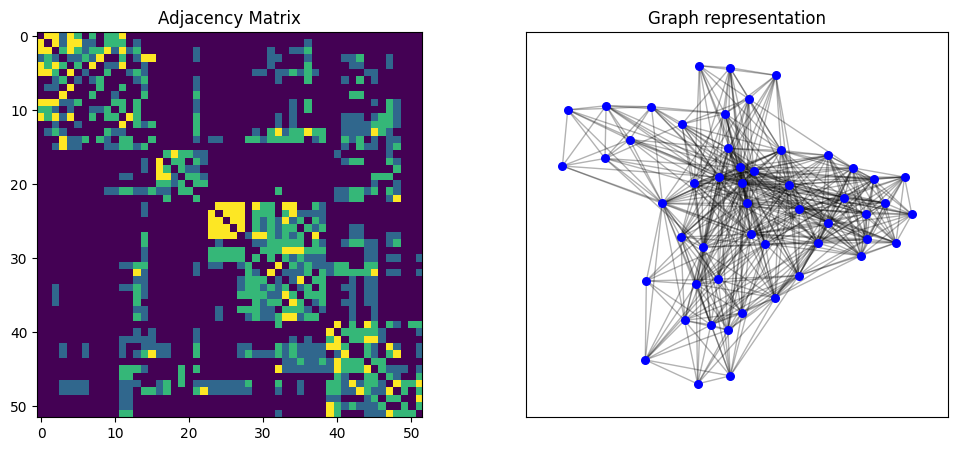

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.from_numpy_array(cat)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.imshow(cat)

loc = nx.spring_layout(G)
nx.draw_networkx_nodes(G, loc, node_size=30, node_color='b', ax=ax2)
nx.draw_networkx_edges(G, loc, alpha=0.3, ax=ax2)

ax1.set_title("Adjacency Matrix")
ax2.set_title("Graph representation")
plt.show()

This is a connectivity matrix representing functional connectivity between 52 regions in a cat brain. As far as I am aware, the cat was not harmed while collecting this data. We can represent this matrix as a graph, and calculate graph metrics, like the tendency of the network to form clusters and communities, or the average distance between two nodes, also called the path length of the network.

There are some networks that are both highly clustered, with a small average path length between nodes. This is known as the "small-world effect", made famous by the game [Six Degrees of Kevin Bacon](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon).

We can actually quantify this small world effect in a metric known as the small world propensity. In order to calculate this value, we compare the sample network to regular lattices and completely random networks, and see how much the sample network path lengths and clustering differs from the regular and random networks. For a network to be small world, it has the short path lengths of random networks, and high clustering of regular networks.

The folder `small_world_propensity` contains functions that calculates this value. One of these functions is `get_average_paths`, which - perhaps unsurprisingly - gets the average shortest path length of the network. We will focus on testing and optimizing this particular function.

First, let's look at the output:

In [25]:
np.random.seed(1337)
swp.small_world_propensity(cat)

,Network C,Network L,ΔC,ΔL,SWP,α,δ,Regular C,Random C,Regular L,Random L
0,0.270482,3.566516,0.169904,0.251567,0.785345,0.976783,0.243679,0.296984,0.141,5.889819,2.785596


OK, so that was super fast. Now lets load in a connectivity matrix representing connections in a resistive switching array:

In [26]:
C = np.load('data/C_mat.npy')
C.shape

(805, 805)

So this is quite a bit bigger! Let's see how it runs...

In [27]:
np.random.seed(1337)

swp.small_world_propensity(C)

,Network C,Network L,ΔC,ΔL,SWP,α,δ,Regular C,Random C,Regular L,Random L
0,0.042583,11.987697,0.0,0.232254,0.835772,1.570796,1.0,0.04078,0.039689,26.247016,7.67405


12s might not seem a lot, but suppose you want to generate some data on how SWP changes with size. In order to do this, you'll want to try a range of size, say 5,000. And since SWP contains an element of stochasticity, you'll need to run each network to get a mean and variance, so maybe 100 different instances. That's 500,000 runs.

It's going to take you well over 1,500 hours to run all of these networks! That's preposterous. If you have an 8 core processor you can cut this down to 200 hours (or about 8 days), with parallization. Assuming you don't mind thrashing your Macbook Pro M1...

## Testing

Before we optimize anything, lets look at how we test the `get_average_paths` function.

unittest comes prepackaged with lots of tools that can help prepare your test cases. We look at three of the most basic here:

`assertTrue(A)`

where A is a bool. If A is `False`, then the test case fails. Of course, the opposite method `assertFalse` also exists.

`assertEqual(A, B)`

In this case, if `A == B`, the case passes, otherwise it fails. Note that `A` and `B` have to be EXACTLY equal. Sometimes you just want to make sure the values are approximately equal. Sometimes two values can be different due to rounding, or numerical precision. For this, we have

`assertAlmostEqual(A, B, places)`

where `places` is the number of decimal places to consider. So the following

`assertAlmostEqual(1.22223, 1.22225, places=4)`

will pass.

We can use these methods to make some basic tests for our purposes. Below, we test an empty graph, a graph with a single node, and graphs with odd and even numbers of nodes.

In [ ]:
import unittest

from small_world_propensity import get_average_paths
from scipy.sparse import csgraph
import math

class TestGetAveragePaths(unittest.TestCase):
    def test_empty_graph(self):
        # Test when the input matrix is an empty graph (all zeros)
        W = np.zeros((5, 5))
        result = get_average_paths(W)
        print(result)
        self.assertTrue(math.isinf(result) or math.isnan(result))

    def test_single_node(self):
        # Test when there is a single node in the graph
        W = np.array([[0]])
        result = get_average_paths(W)
        self.assertTrue(math.isnan(result))

    def test_two_connected_nodes(self):
        # Test when there are only two connected nodes
        W = np.array([[0, 1], [1, 0]])
        result = get_average_paths(W)
        self.assertEqual(result, 1.0)

    def test_odd_number_of_nodes(self):
        # Test when there is an odd number of nodes in the graph
        W = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
        result = get_average_paths(W)
        self.assertAlmostEqual(result, 1.3333, places=4)

    def test_even_number_of_nodes(self):
        # Test when there is an even number of nodes in the graph
        W = np.array([[0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0]])
        result = get_average_paths(W)
        self.assertAlmostEqual(result, 1.6667, places=4)

We can write this to a file, and use the integrated testing extension in VSCode to run our tests.

## cProfile
Let's use cProfile and try and find where we are spending time. `cat` is too small and `C` is too big, so we try an intermediate network instead.

In [36]:
import cProfile

In [37]:
B = np.load('data/B_mat.npy')
B.shape

(361, 361)

`cProfile` has a method called `run`. This method takes as an argument whatever program you want to run, but it has to be as a string. You can also choose how you want the results to be displayed. We use `sort='cumtime'` to show the cumulative time spent in a particular part of the code.

In [38]:
cProfile.run('swp.small_world_propensity(B)', sort='cumtime')

         422115 function calls (422084 primitive calls) in 1.392 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.392    1.392 {built-in method builtins.exec}
        1    0.000    0.000    1.392    1.392 <string>:1(<module>)
        1    0.000    0.000    1.392    1.392 small_world_propensity.py:15(small_world_propensity)
        1    0.002    0.002    1.391    1.391 small_world_propensity.py:40(_small_world_propensity)
        3    0.002    0.001    0.694    0.231 small_world_propensity.py:146(get_average_paths)
        3    0.667    0.222    0.667    0.222 {method 'average_path_length' of 'igraph._igraph.GraphBase' objects}
        1    0.122    0.122    0.658    0.658 small_world_propensity.py:201(regular_matrix_generator)
   417870    0.527    0.000    0.527    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
        1    0.020    0.020    0.022    0.022 small_worl

So how do we interpret the above? We have sorted by cumulative time. The top 4 entries are essentially just calls to the main function, telling us how long we spend inside `small_world_propensity`. Next we can see that `get_average_paths` is taking an awful long time! We are spending just over half of our time inside this function! What's next on the list? generating some random integers is taking up most of the rest of the time, but we can't really avoid this. Perhaps there are more efficient random number generators that we can use?

Let's start with the path length. Let's look at the `get_average_paths` function:

```python
def get_average_paths(W: np.ndarray) -> float:
    """Get the average shortest path length of W

    Args:
        W (np.ndarray): Symmetric adjacency matrix

    Returns:
        float: Average shortest path lengths.
    """
    igG = ig.Graph.Weighted_Adjacency((1/W).tolist(), mode="UNDIRECTED")
    L_W = igG.average_path_length(weights="weight")

    return L_W
```

The details aren't really important, but we are converting our matrix into a graph using the `igraph` library, and then using a method from that library to get the path lengths. In our research, we discover that `scipy` has a sparse graph library that might be useful. We know that our graphs are sparse, so perhaps this will be more efficient...

We can rewrite our function as follows:

```python
def get_average_paths(W: np.ndarray) -> float:
    """Get the average shortest path length of W

    Args:
        W (np.ndarray): Symmetric adjacency matrix

    Returns:
        float: Average shortest path lengths.
    """
    path_matrix = csgraph.shortest_path(1/W, directed=False, unweighted=False)
    L_W = np.triu(path_matrix).sum() / (len(W) * (len(W) - 1) / 2)

    return L_W
```

Now we make the substitution. This also means that we now no longer need to include the weighty `igraph` package, so we take that out as well, and rerun the tests...

All tests pass, so now we can try profiling again. Remember, you will need to restart the kernel.

In [1]:
import small_world_propensity as swp

import scipy.io as sio
import numpy as np
import cProfile

B = np.load('data/B_mat.npy')
B.shape

(361, 361)

In [2]:
cProfile.run('swp.small_world_propensity(B)', sort='cumtime')

         432156 function calls (432041 primitive calls) in 0.817 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.817    0.817 {built-in method builtins.exec}
        1    0.000    0.000    0.817    0.817 <string>:1(<module>)
        1    0.000    0.000    0.817    0.817 small_world_propensity.py:13(small_world_propensity)
        1    0.000    0.000    0.817    0.817 small_world_propensity.py:38(_small_world_propensity)
        1    0.136    0.136    0.608    0.608 small_world_propensity.py:199(regular_matrix_generator)
   423544    0.462    0.000    0.462    0.000 {method 'integers' of 'numpy.random._generator.Generator' objects}
        3    0.000    0.000    0.165    0.055 small_world_propensity.py:144(get_average_paths)
        3    0.148    0.049    0.165    0.055 {scipy.sparse.csgraph._shortest_path.shortest_path}
        1    0.021    0.021    0.023    0.023 small_world_propensity.p

In [3]:
C = np.load('data/C_mat.npy')
swp.small_world_propensity(C)

,Network C,Network L,ΔC,ΔL,SWP,α,δ,Regular C,Random C,Regular L,Random L
0,0.042583,11.987697,0.0,0.232229,0.83579,1.570796,1.0,0.04078,0.039691,26.247026,7.674664


Great! We have cut the time to around 45% of the original. Let's see if we can do something about the randomness...we can use the magic function called timeit to compare simple function calls.

In [19]:
%%timeit
np.random.randint(0,10000)

1.28 µs ± 5.06 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


The default random number generator is PCG64, which is quite fast. But as we talked about in the first Lab, this method isn't the preferred way of generating random numbers. So let's try using the `Generator` class and the `SFC64` algorithm.

In [21]:
from numpy.random import Generator, PCG64, SFC64

rngPC = Generator(PCG64(1337))
rngSF = Generator(SFC64(1337))


In [22]:
%%timeit
rngPC.integers(0,10000)

1.05 µs ± 5.94 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [24]:
%%timeit
rngSF.integers(0,10000)

1.03 µs ± 3.82 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


So this method is a bit faster, with `SFC64` giving trivially better performance. So we'll make an update to our function, and also make sure that we can pass a seed so that we can iterate over many instances.

In [1]:
import small_world_propensity as swp
import numpy as np

In [2]:
C = np.load('data/C_mat.npy')
swp.small_world_propensity(C, seed=1337)


,Network C,Network L,ΔC,ΔL,SWP,α,δ,Regular C,Random C,Regular L,Random L
0,0.042583,11.987697,0.0,0.232073,0.8359,1.570796,1.0,0.04078,0.039689,26.247057,7.67842


In [7]:
cat = sio.loadmat('data/cat.mat')['CIJctx']

swp.small_world_propensity(cat, 1337)

,Network C,Network L,ΔC,ΔL,SWP,α,δ,Regular C,Random C,Regular L,Random L
0,0.270482,3.566516,0.170363,0.247591,0.787485,0.968113,0.232639,0.29693,0.141686,5.874811,2.806938


So not really a whole lot of gain, but now the user at least has more control over seeding the random number generator. If other researchers want to replicate your code, then they can simply use the same initial seed.